# Import Libararies

# Convert the dataset into numpy arrays, or retrieve pickled objects

In [19]:
import cv2 # need cmake for gpu acceleration
import numpy as np
import os
import random
from random import shuffle # shuffle data to randomise input to improve accuracy, still dont know why
import matplotlib.pyplot as plt
import pickle
from prettytable import PrettyTable
import tensorflow as tf
import tqdm
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns

In [ ]:
train=r"D:/Project Based/CT"
cat=["healthypng","covidpng","pneumoniapng"]
#quick note on data cleaning, you need to first convert the dataset to PNG,␣
#,→then to prevent incomptiable input shapes convert from RGB to Grayscale,␣
#,→then downsample to not fry you CPU with 1000s of images of millions of␣
#,→arrays elements.
data=[]
Model="CT"
for i in cat:
    path=os.path.join(train,i)
    label=cat.index(i)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        img_arr=cv2.imread(img_path,0)
        #img_arr = tf.reshape(img_arr, [-1, 256, 256, 3]
        #img_arr=tf.image.resize(img_arr, [256,256])#no need
        data.append([img_arr,label])
shuffle(data)
x=[]
y=[]
x_test=[]
y_test=[]
for features,labels in data:
    x.append(features)
    y.append(labels)
x_test=np.array(x[int(len(x)*0.9):-1])
y_test=np.array(y[int(len(y)*0.9):-1])
x=np.array(x[0:int(0.9*len(x))])
y=np.array(y[0:int(0.9*len(y))])
x=x/255
x_test=x_test/255
data.clear()# reduce overhead
x=x.reshape(len(x),256,256,1)# for some reason my PC started running out of␣
#,→memory often while training the same model
# so as a solution i tried to treat any image as a grayscale to save 3 times␣
#,→the memory when conveting the image to numpy arrays
# and not exhaust gpu while training the model.
x_test=x_test.reshape(len(x_test),256,256,1)# it worked lol as i expected since␣
#→x.pkl went from 12GB to 4GB


In [ ]:
pickle.dump(x,open('x2.pkl','wb'))
pickle.dump(y,open('y2.pkl','wb'))
pickle.dump(x_test,open('x_test2.pkl','wb'))
pickle.dump(y_test,open('y_test2.pkl','wb'))

# Build the CNet

In [2]:
x=pickle.load(open('x2.pkl','rb'))
x_test=pickle.load(open('x_test2.pkl','rb'))
y=pickle.load(open('y2.pkl','rb'))
y_test=pickle.load(open('y_test2.pkl','rb'))

## Calculate the accuracy from a test dataset

In [3]:
def Train():
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=x.shape[1:],activation="relu",padding="same"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64,activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5))


    model.add(tf.keras.layers.Dense(64,activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))


    model.add(tf.keras.layers.Dense(3,activation="softmax"))


    model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['acc']) # or binary_crossentropy
    model.fit(x,y,epochs=6,validation_split=0.1) # epochs:iteration , validation_split=split your training set to test the model after every epoch
    return model

In [4]:
model=Train()
loss,win=model.evaluate(x_test,y_test)# test using evaluate
print('loss: {}, acc: {}'.format(loss,win))
model.summary()

Epoch 1/6
429/429 [==============================] - 70s 145ms/step - loss: 0.9720 - acc: 0.5912 - val_loss: 0.3395 - val_acc: 0.8707
Epoch 2/6
429/429 [==============================] - 59s 138ms/step - loss: 0.4207 - acc: 0.8209 - val_loss: 0.2898 - val_acc: 0.8969
Epoch 3/6
429/429 [==============================] - 60s 139ms/step - loss: 0.3041 - acc: 0.8797 - val_loss: 0.2105 - val_acc: 0.9225
Epoch 4/6
429/429 [==============================] - 60s 139ms/step - loss: 0.2321 - acc: 0.9114 - val_loss: 0.2045 - val_acc: 0.9245
Epoch 5/6
429/429 [==============================] - 60s 140ms/step - loss: 0.1940 - acc: 0.9248 - val_loss: 0.1894 - val_acc: 0.9396
Epoch 6/6
53/53 [==============================] - 3s 65ms/step - loss: 0.2094 - acc: 0.9190
loss: 0.20944926142692566, acc: 0.9189828634262085
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None

## Saving the model after achieving 89% percentage

In [ ]:
model.save("ULT_CT_XRAY_CONV")

In [3]:
model=tf.keras.models.load_model("ULT_CT_XRAY_CONV")

# Strandradized Table for the model acuuaracy and after 30 runs.

In [ ]:
for i in range(30):
    model=Train()
    test=model.evaluate(x_test,y_test)
    with open(r'avg.txt','a+') as file:
        file.write("{},{}\n".format(test[1],test[0]))

# Confusion Matrix 

In [5]:
tb=PrettyTable()
tb.field_names = ["-ve True", "-ve False", "+ve True", "+ve False"]

def generate():
    predict=model.predict([x_test])
    a,b,c,d=0,0,0,0
    for i in range(1,len(predict)-1):
        if predict[i][0]>predict[i][1] and max(predict[i][0:2])>predict[i][2] and y_test[i]==0:
            a+=1
        elif predict[i][0]>=predict[i][1] and max(predict[i][0:2])>predict[i][2] and y_test[i]==1:
            b+=1
        elif predict[i][0]<predict[i][1] and max(predict[i][0:2])>predict[i][2] and y_test[i]==1:
            c+=1
        elif predict[i][0]<=predict[i][1] and max(predict[i][0:2])>predict[i][2] and y_test[i]==0:
            d+=1
    return a,b,c,d
a,b,c,d=generate()
tb.add_row([a,b,c,d])
print(tb)

+----------+-----------+----------+-----------+
| -ve True | -ve False | +ve True | +ve False |
+----------+-----------+----------+-----------+
|   459    |     77    |   559    |     22    |
+----------+-----------+----------+-----------+


C:\Users\omara\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
True


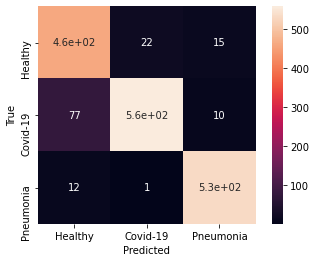

In [24]:
singlepredict=[]
singletest=[]
predict=model.predict([x_test])
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())# if false then confusion.numpy will produce error
singlepredict=np.argmax(predict,1)
singletest=np.array(y_test)
confusion=tf.math.confusion_matrix(labels=singletest, predictions=singlepredict).numpy()
#plt.imshow(confusion) # Green Confusion Matrix
sns.heatmap(confusion , annot=True , xticklabels=['Healthy' , 'Covid-19','Pneumonia'] , yticklabels=['Healthy' , 'Covid-19','Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Metrics

In [28]:
precision, recall, f1, _ = score(singletest, singlepredict)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(f1))

precision: [0.83818182 0.9604811  0.95527728]
recall: [0.92570281 0.86532508 0.976234  ]
fscore: [0.87977099 0.91042345 0.96564195]


In [ ]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
val_loss = model.history.history['val_loss']
loss = model.history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, [i*100 for i in acc], 'green', label='Training acc')
plt.plot(epochs,[i*100 for i in val_acc], 'blue', label='Validation acc')

plt.plot(epochs, [i*100 for i in loss], 'red', label='Training loss')
plt.plot(epochs,[i*100 for i in val_loss], 'black', label='Validation loss')
plt.title('Training, validation accuaracy and loss over epochs')#'Training and validation loss'
plt.legend()

plt.show()

# Some visulization into some cases in the dataset, the prediction and the true output.

In [29]:
predict=model.predict([x_test]) # ignore if you run the cells above

C:\Users\omara\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


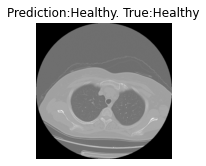

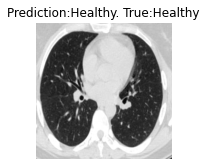

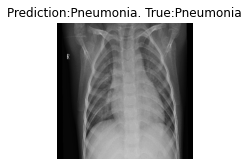

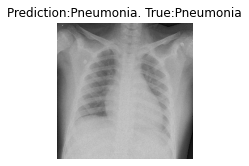

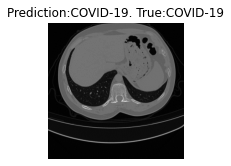

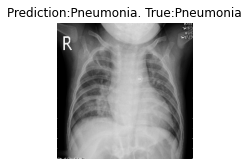

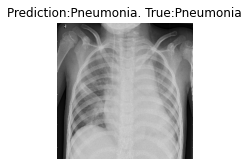

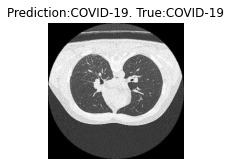

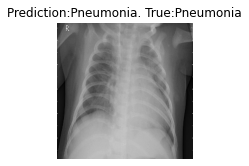

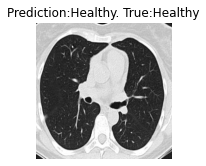

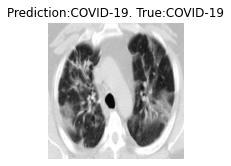

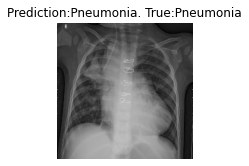

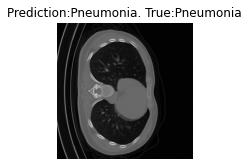

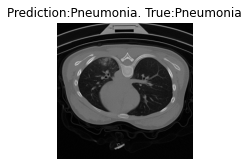

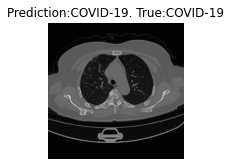

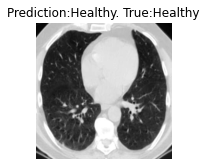

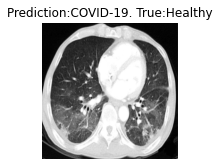

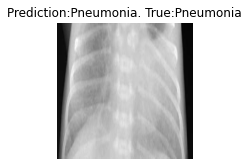

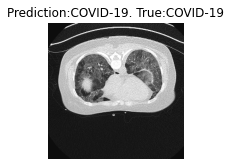

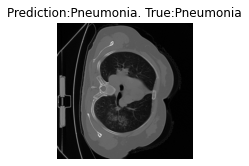

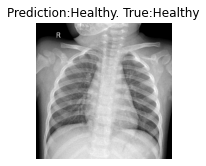

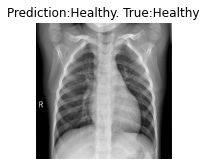

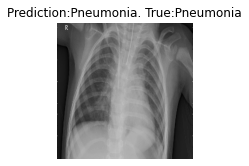

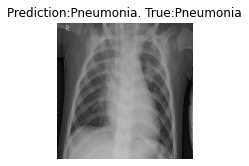

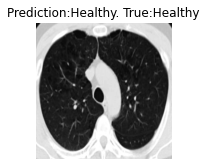

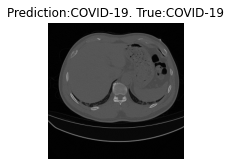

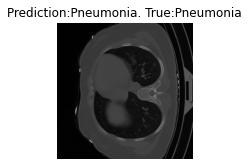

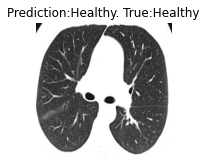

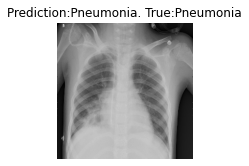

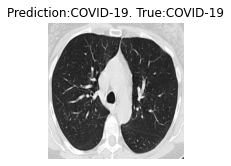

In [30]:
def simpleargmax(n):
    if list(n).index(max(n))==0:
        return "Healthy"
    elif list(n).index(max(n))==1:
        return "COVID-19"
    else:
        return "Pneumonia"
def label(m):
    if m==0:
        return "Healthy"
    elif m==1:
        return "COVID-19"
    else:
        return "Pneumonia"
for i in range(30):
    plt.figure(figsize = (2.5,2.5))
    val=random.randint(0,len(x_test)-1)
    plt.axis("off")
    plt.imshow(x_test[val], cmap='gray')
    plt.title("Prediction:{}. True:{}".format(simpleargmax(predict[val]),label(y_test[val])))
    plt.show()